<a href="https://colab.research.google.com/github/Duncan1738/AI-in-Game-Development/blob/main/AI_in_Game_Development_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

<ipython-input-2-a9bc8e5ab309>:176: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f"{frame_folder}/frame_{frame}.png") for frame in range(frames)]


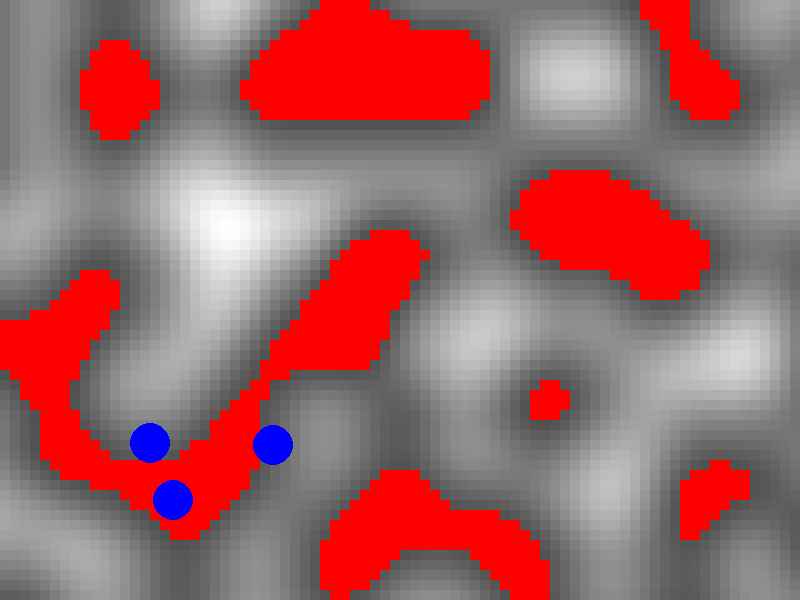

In [2]:
# ========================
# 📌 Install Dependencies
# ========================
!apt-get update
!apt-get install -y python-opengl ffmpeg
!pip install pygame numpy tensorflow noise imageio requests

import pygame
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from noise import pnoise2
from IPython.display import display as ipy_display, Image
import os
import imageio
import requests

# ===========================
# 🎮 Initialize Pygame
# ===========================
pygame.init()

# Screen dimensions
WIDTH, HEIGHT = 800, 600
GRID_SIZE = 10

# Create an off-screen Pygame surface (no display needed)
screen = pygame.Surface((WIDTH, HEIGHT))

# Colors
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
RED = (255, 0, 0)

# ===========================
# 📥 Download NPC Sprite (If Available)
# ===========================
npc_sprite_url = "https://upload.wikimedia.org/wikipedia/commons/4/4e/Pacman.png"
npc_sprite_path = "/content/npc_sprite.png"

try:
    response = requests.get(npc_sprite_url, timeout=10)
    if response.status_code == 200:
        with open(npc_sprite_path, "wb") as file:
            file.write(response.content)
        print("✅ Sprite downloaded successfully!")
    else:
        raise Exception("⚠️ Sprite download failed!")
except:
    print("⚠️ Error downloading sprite! Using default shape.")
    npc_sprite_path = None  # Set to None if sprite is unavailable

# ===========================
# 🌍 Procedural Terrain Generation (Perlin Noise)
# ===========================
def generate_perlin_terrain(width, height, scale=0.07):
    terrain = np.zeros((height, width))
    obstacles = []
    for y in range(height):
        for x in range(width):
            noise_val = pnoise2(x * scale, y * scale)
            terrain[y][x] = noise_val
            if noise_val < -0.2:  # Lower threshold for smoother obstacles
                obstacles.append((x * GRID_SIZE, y * GRID_SIZE))
    return ((terrain - terrain.min()) / (terrain.max() - terrain.min()) * 255).astype(np.uint8), obstacles

terrain_map, obstacles = generate_perlin_terrain(WIDTH // GRID_SIZE, HEIGHT // GRID_SIZE)

# ===========================
# 🧠 AI Model for NPC Decision Making
# ===========================
def create_npc_ai():
    model = Sequential([
        tf.keras.Input(shape=(2,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

npc_ai = create_npc_ai()

# ===========================
# 🏋️ Train AI Model
# ===========================
def generate_training_data(samples=2000):
    X_train, Y_train = [], []
    for _ in range(samples):
        x, y = random.uniform(0, 1), random.uniform(0, 1)
        dx, dy = random.choice([-1, 0, 1]) * 0.05, random.choice([-1, 0, 1]) * 0.05
        if dx == 0 and dy == 0:
            dx, dy = 0.05, 0.05
        X_train.append([x, y])
        Y_train.append([dx, dy])
    return np.array(X_train), np.array(Y_train)

X_train, Y_train = generate_training_data()
npc_ai.fit(X_train, Y_train, epochs=15, verbose=0)

# ===========================
# 🤖 Improved NPC AI Movement
# ===========================
class NPC:
    def __init__(self):
        self.x = random.randint(50, WIDTH - 50)
        self.y = random.randint(50, HEIGHT - 50)
        self.speed = 3

        # Load Better NPC Sprite or Use a Default Shape
        if npc_sprite_path:
            try:
                self.sprite = pygame.image.load(npc_sprite_path)
                self.sprite = pygame.transform.scale(self.sprite, (40, 40))  # Larger size
            except pygame.error:
                self.sprite = None
        else:
            self.sprite = None

    def move(self):
        input_data = np.array([[self.x / WIDTH, self.y / HEIGHT]])
        move = npc_ai.predict(input_data, verbose=0)[0]

        dx, dy = move[0] * self.speed * 5, move[1] * self.speed * 5
        new_x, new_y = self.x + int(dx), self.y + int(dy)

        # Avoid obstacles
        if not any(abs(new_x - ox) < GRID_SIZE and abs(new_y - oy) < GRID_SIZE for ox, oy in obstacles):
            self.x, self.y = new_x, new_y

        # Boundary constraints
        self.x = max(10, min(WIDTH - 10, self.x))
        self.y = max(10, min(HEIGHT - 10, self.y))

    def draw(self):
        if self.sprite:
            screen.blit(self.sprite, (self.x, self.y))
        else:
            pygame.draw.circle(screen, BLUE, (self.x, self.y), 20)  # Default circle

# ===========================
# 🎮 Improved Game Loop (Save Frames)
# ===========================
npcs = [NPC() for _ in range(3)]
frames = 20
frame_folder = "/content/frames"

os.makedirs(frame_folder, exist_ok=True)

for frame in range(frames):
    screen.fill(WHITE)

    # Generate smoother terrain
    for i in range(WIDTH // GRID_SIZE):
        for j in range(HEIGHT // GRID_SIZE):
            color = terrain_map[j, i]
            pygame.draw.rect(screen, (color, color, color), (i * GRID_SIZE, j * GRID_SIZE, GRID_SIZE, GRID_SIZE))

    # Draw smoother obstacles
    for ox, oy in obstacles:
        pygame.draw.rect(screen, RED, (ox, oy, GRID_SIZE, GRID_SIZE))

    # Move and draw NPCs
    for npc in npcs:
        npc.move()
        npc.draw()

    # Save each frame
    frame_path = f"{frame_folder}/frame_{frame}.png"
    pygame.image.save(screen, frame_path)

# Convert frames to GIF
gif_path = "/content/npc_game.gif"
images = [imageio.imread(f"{frame_folder}/frame_{frame}.png") for frame in range(frames)]
imageio.mimsave(gif_path, images, duration=0.1)

# Display GIF in Colab
ipy_display(Image(gif_path))
